In [1]:
import pandas as pd
import numpy as np
import math
import os
import glob
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tweets_df = pd.read_csv("/content/drive/Shareddrives/CS229_Final/Data/Bitcoin_tweets.csv")

In [4]:
def get_time(time_str):
  timestamp = int(math.floor(datetime.strptime(time_str, '%d/%m/%y %H:%M').timestamp()))
  return timestamp

def checkKey(dict, key):
    if key in dict:
      return True
    else:
        return False

In [5]:
tweets_dict = {}

for i in range(len(tweets_df)):
  time_str = tweets_df['date'].iloc[i]
  if isinstance(time_str, str):
    timestamp = get_time(time_str)
    if checkKey(tweets_dict, timestamp):
      tweets_dict[timestamp] += [tweets_df['text'].iloc[i]]
    else:
      tweets_dict[timestamp] = [tweets_df['text'].iloc[i]]

Add Original Tweets

In [6]:
def get_timestamp_og(time_str): #returns timestamp for the minute the time is in
  return int(math.floor(datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S').timestamp()/60)*60) 

In [7]:
os.chdir("/content/drive/Shareddrives/CS229_Final/Data/Tweets")
file_extension = 'csv'
all_filenames = [i for i in glob.glob("*.{}".format(file_extension))]
extra_tweets = pd.concat([pd.read_csv(f) for f in all_filenames], axis=0)

In [8]:
for i in range(len(extra_tweets)):
  time_str = extra_tweets['0'].iloc[i]
  if isinstance(time_str, str):
    timestamp = get_timestamp_og(time_str)
    if checkKey(tweets_dict, timestamp):
      tweets_dict[timestamp] += [extra_tweets['tweets'].iloc[i]]
    else:
      tweets_dict[timestamp] = [extra_tweets['tweets'].iloc[i]]

In [9]:
timestamps = np.array(list(tweets_dict.keys()))

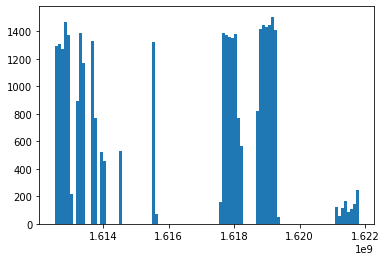

In [10]:
plt.hist(timestamps, bins=100)
plt.show()

In [11]:
min = timestamps.min()
max = timestamps.max()

In [12]:
def get_date_string(timestamp):
  return datetime.strftime(datetime.fromtimestamp(timestamp), '%Y-%m-%d %H:%M:%S')
print(get_date_string(max))
print(get_date_string(min))

2021-05-23 23:59:00
2021-02-05 10:52:00


Prices

In [17]:
os.chdir("/content/drive/Shareddrives/CS229_Final/Data/Price")
file_extension = 'csv'
all_filenames = [i for i in glob.glob("*.{}".format(file_extension))]
print(all_filenames)
print(len(all_filenames))

['BTCUSDT-1m-2021-02.csv', 'BTCUSDT-1m-2021-01.csv', 'BTCUSDT-1m-2021-03.csv', 'BTCUSDT-1m-2021-04.csv', 'BTCUSDT-1m-2021-05-01.csv', 'BTCUSDT-1m-2021-05-02.csv', 'BTCUSDT-1m-2021-05-03.csv', 'BTCUSDT-1m-2021-05-04.csv', 'BTCUSDT-1m-2021-05-05.csv', 'BTCUSDT-1m-2021-05-06.csv', 'BTCUSDT-1m-2021-05-07.csv', 'BTCUSDT-1m-2021-05-08.csv', 'BTCUSDT-1m-2021-05-09.csv', 'BTCUSDT-1m-2021-05-10.csv', 'BTCUSDT-1m-2021-05-11.csv', 'BTCUSDT-1m-2021-05-12.csv', 'BTCUSDT-1m-2021-05-13.csv', 'BTCUSDT-1m-2021-05-14.csv', 'BTCUSDT-1m-2021-05-15.csv', 'BTCUSDT-1m-2021-05-16.csv', 'BTCUSDT-1m-2021-05-17.csv', 'BTCUSDT-1m-2021-05-18.csv', 'BTCUSDT-1m-2021-05-19.csv', 'BTCUSDT-1m-2021-05-20.csv', 'BTCUSDT-1m-2021-05-21.csv', 'BTCUSDT-1m-2021-05-22.csv', 'BTCUSDT-1m-2021-05-23.csv', 'BTCUSDT-1m-2021-05-24.csv', 'BTCUSDT-1m-2021-05-25.csv']
29


In [18]:
header = ["Open time", "Open", "High", "Low", 
          "Close", "Volume", "Close time","Quote asset volume", 
          "Number of trades", "Taker buy base asset volume",
          "Taker buy quote asset volume", "Ignore"]
prices = pd.concat([pd.read_csv(f, names=header) for f in all_filenames ], axis=0)
prices = prices.sort_values(by=['Open time'])

In [19]:
times = [1440] #+ [60*(i+1) for i in range(12)]

In [20]:
def get_price_deltas(times, prices):
  price_deltas = {}
  for time in times:
    price_deltas[time] = {}
  for open_index in range(len(prices)-times[len(times)-1]):
    open_price = prices['Close'].iloc[open_index]
    for time in times:
      close_index = open_index + time
      close_price = prices['Close'].iloc[close_index]
      percent = (close_price-open_price)/open_price
      price_deltas[time][prices['Open time'].iloc[open_index]] = percent
  return price_deltas
  
deltas = get_price_deltas(times, prices)

In [32]:
def get_labels_three(deltas):
  price_labels = {}
  for time in deltas.keys():
    price_labels[time] = {}
    positives = []
    negatives = []
    for val in deltas[time].values():
      if val >= 0:
        positives += [val]
      else:
        negatives += [val]
    nth_largest = sorted(positives)[int(0.2*len(positives))]
    nth_smallest = sorted(negatives)[int(0.8*len(negatives))]
    for timestamp in deltas[time].keys():
      if deltas[time][timestamp] >= nth_largest:
        price_labels[time][int(timestamp/1000)] = 1
      elif deltas[time][timestamp] <= nth_smallest:
        price_labels[time][int(timestamp/1000)] = -1
      else:
        price_labels[time][int(timestamp/1000)] = 0
  return price_labels

def get_labels_two(deltas):
  price_labels = {}
  for time in deltas.keys():
    price_labels[time] = {}
  for time in deltas.keys():
    for timestamp in deltas[time].keys():
      if deltas[time][timestamp] > 0:
        price_labels[time][int(timestamp/1000)] = 1
      elif deltas[time][timestamp] < 0:
        price_labels[time][int(timestamp/1000)] = -1
      else:
        n = np.random.rand()
        if n >= 0.5:
          price_labels[time][int(timestamp/1000)] = 1
        else:
          price_labels[time][int(timestamp/1000)] = -1
  return price_labels

labels = get_labels_two(deltas)

In [22]:
print(tweets_dict[1613001540])
print(labels[1440][1613001540])

['Blue Ridge Bank shares halted by NYSE after #bitcoin ATM announcement https://t.co/xaaZmaJKiV @MyBlueRidgeBank… https://t.co/sgBxMkP1SI']
1


In [35]:
count = 0
for key in tweets_dict.keys():
  count += len(tweets_dict[key])
print(count)

272304


In [36]:
len(tweets_dict)

34294

Code for Exporting into CSV

In [23]:
final_dict = {}
for timestamp in tweets_dict.keys(): 
  if timestamp in  labels[1440].keys():
  #print(labels[15][timestamp])
    final_dict[timestamp] = {"tweets_dict" : " ".join(tweets_dict[timestamp]), "label" : labels[1440][timestamp]}

In [24]:
df = pd.DataFrame.from_dict(final_dict, orient = 'index')

In [31]:
df[195:200]

,tweets_dict,label
1612988520,#BITCOIN IS A BUY!! HOLD #BTC AND YOU WILL BE ...,1
1612988460,@WSBChairman Own half of one doing alt coin tr...,1
1612988400,#Bitcoin #BTC #XBT\nIf $BTC price temporarily ...,1
1612988340,Huge Changes Begin Quietly! #digitalassetmanag...,1
1612988280,$aave #aave target for $1k is ahead\n\nmove is...,1


In [ ]:
 #df.to_csv('final3.csv', index=False)

In [ ]:
x = df["label"].values

In [ ]:
plt.hist(x)